In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json

Configure the ERDDAP to search

In [2]:
ra = 'maracoos'

with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

https://erddap.maracoos.org/erddap


Pull in the processed inventory

In [3]:
#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).

df = pd.read_excel('2021/data/processed/%s.xlsx' % ra.upper(), dtype=str)
df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,MARACOOS,Iron_Pot_Landing,N/A: No WMO numbers,Iron_Pot_Landing - Maryland DNR Station,Maryland Department of Natural Resources water...,38.796,-76.7208,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
1,MARACOOS,Jug_Bay,N/A: No WMO numbers,Jug_Bay - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7813,-76.7137,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
2,MARACOOS,Mataponi,N/A: No WMO numbers,Mataponi - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7433,-76.7074,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
3,MARACOOS,Aquarium_West,N/A: No WMO numbers,Aquarium_West - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2854,-76.6088,fixed,2016,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
4,MARACOOS,Aquarium_East,N/A: No WMO numbers,Aquarium_East - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2855,-76.608,fixed,2016,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
5,MARACOOS,Pleasure_Island,N/A: No WMO numbers,Pleasure_Island - Maryland DNR Station,Maryland Department of Natural Resources water...,39.2282,-76.4006,fixed,2015,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
6,MARACOOS,Sandy_Pt_South_Beach,N/A: No WMO numbers,Sandy_Pt_South_Beach - Maryland DNR Station,Maryland Department of Natural Resources water...,39.0075,-76.4003,fixed,2004,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
7,MARACOOS,Tinghman_Island,N/A: No WMO numbers,Tinghman_Island - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7037,-76.3453,fixed,2017,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
8,MARACOOS,Taylors_Island,N/A: No WMO numbers,Taylors Island - Maryland DNR Station,Maryland Department of Natural Resources water...,38.4418,-76.3029,fixed,2017,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
9,MARACOOS,Otter_Point_Creek,N/A: No WMO numbers,Otter_Point_Creek - Maryland DNR Station,Maryland Department of Natural Resources water...,39.4508,-76.2746,fixed,2003,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN


Search the ERDDAP server for a single station of interest - more of a test

In [4]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [5]:
df_wf = df[df['Station ID'] == 'Jug_Bay']

# for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
search_for = df_wf['Station ID'].to_string()

search_url = e.get_search_url(search_for=search_for, response="csv")

try:
    resp = pd.read_csv(search_url)
    print(resp['Station ID'])
except:
    pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [6]:
not_found = []
found = dict()

exclude = ' -gliders'

search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

for search1 in df[search_order[0]].astype(str):
    
    if search1 == "nan":
        print("punting with station long name = nan\n")
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Station ID" = "Iron_Pot_Landing"
Found "Iron_Pot_Landing": ['mddnr_Iron_Pot_Landing']


searching "Station ID" = "Jug_Bay"
Found "Jug_Bay": ['mddnr_Jug_Bay']


searching "Station ID" = "Mataponi"
Found "Mataponi": ['mddnr_Mataponi']


searching "Station ID" = "Aquarium_West"
Found "Aquarium_West": ['mddnr_Aquarium_West']


searching "Station ID" = "Aquarium_East"
Found "Aquarium_East": ['mddnr_Aquarium_East_-_Bottom', 'mddnr_Aquarium_East_-_Surface']


searching "Station ID" = "Pleasure_Island"
Found "Pleasure_Island": ['mddnr_Pleasure_Island']


searching "Station ID" = "Sandy_Pt_South_Beach"
no dataset matching "Sandy_Pt_South_Beach"
searching "Station Long Name" = "Sandy_Pt_South_Beach - Maryland DNR Station"
searching "WMO ID or NWS/CMAN ID" = "N/A: No WMO numbers"
Couldn't find: ['Sandy_Pt_South_Beach', 'Sandy_Pt_South_Beach - Maryland DNR Station', 'N/A: No WMO numbers']


searching "Station ID" = "Tinghman_Island"
no dataset matching "Tinghman_Island"
searching "Stati

no dataset matching "Norrie Point"
searching "Station Long Name" = "Norrie Point hydro/weather station - HRECOS"
searching "WMO ID or NWS/CMAN ID" = "N/A: No WMO numbers"
Couldn't find: ['Norrie Point', 'Norrie Point hydro/weather station - HRECOS', 'N/A: No WMO numbers']


searching "Station ID" = "Mowhawk R. Rexford Bridge"
no dataset matching "Mowhawk R. Rexford Bridge"
searching "Station Long Name" = "Mowhawk R. Rexford Bridge hydrologic station - HRECOS"
searching "WMO ID or NWS/CMAN ID" = "N/A: No WMO numbers"
Couldn't find: ['Mowhawk R. Rexford Bridge', 'Mowhawk R. Rexford Bridge hydrologic station - HRECOS', 'N/A: No WMO numbers']


searching "Station ID" = "Schodak Island Weather"
no dataset matching "Schodak Island Weather"
searching "Station Long Name" = "Schodak Island weather station - HRECOS"
searching "WMO ID or NWS/CMAN ID" = "N/A: No WMO numbers"
Couldn't find: ['Schodak Island Weather', 'Schodak Island weather station - HRECOS', 'N/A: No WMO numbers']


searching "Sta

Print the stations that we couldn't find.

In [7]:
len(not_found)

11

In [8]:
len(found)

32

In [9]:
df.loc[df[search_order[0]].isna()]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes


In [10]:
df[df[search_order[0]].isin(not_found)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
6,MARACOOS,Sandy_Pt_South_Beach,N/A: No WMO numbers,Sandy_Pt_South_Beach - Maryland DNR Station,Maryland Department of Natural Resources water...,39.0075,-76.4003,fixed,2004,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
7,MARACOOS,Tinghman_Island,N/A: No WMO numbers,Tinghman_Island - Maryland DNR Station,Maryland Department of Natural Resources water...,38.7037,-76.3453,fixed,2017,Y,Maryland DNR,N,Maryland DNR,gov_state,Maryland DNR,RPS-ASA,"Fractional_saturation_of_oxygen_in_sea_water, ...",NaN
18,MARACOOS,Pier_26,N/A: No WMO numbers,Pier 26 Weather/Hydro Station - HRECOS,Hudson River Environmental Conditions Observin...,40.721538,-74.0156,fixed,2016,Y,Hudson River Environmental Conditions Observin...,N,Hudson River Environmental Conditions Observin...,nonprofit,Hudson River Environmental Conditions Observin...,RPS-ASA,"air_pressure, air_temperature, dew_point_tempe...",NaN
19,MARACOOS,Pier_84,N/A: No WMO numbers,Pier_84 Hydro/weather Station - HRECOS,Hudson River Environmental Conditions Observin...,40.764628,-74.003186,fixed,2012,Y,Hudson River Environmental Conditions Observin...,N,Hudson River Environmental Conditions Observin...,nonprofit,Hudson River Environmental Conditions Observin...,RPS-ASA,"air_pressure, air_temperature, dew_point_tempe...",NaN
20,MARACOOS,Mowhawk R. Lock 8 weather,N/A: No WMO numbers,Port of Albany hydro/weather station - HRECOS,Hudson River Environmental Conditions Observin...,42.8302,-73.9925,fixed,2012,Y,Hudson River Environmental Conditions Observin...,N,Hudson River Environmental Conditions Observin...,nonprofit,Hudson River Environmental Conditions Observin...,RPS-ASA,"air_pressure, air_temperature, dew_point_tempe...",NaN
21,MARACOOS,Mowhawk R. Lock 8 hydro,N/A: No WMO numbers,Mowhawk R. Lock 8 Hydrologic station - HRECOS,Hudson River Environmental Conditions Observin...,42.8281,-73.9904,fixed,2012,Y,Hudson River Environmental Conditions Observin...,N,Hudson River Environmental Conditions Observin...,nonprofit,Hudson River Environmental Conditions Observin...,RPS-ASA,"dissolved_oxygen_saturation, dissolved_oxygen,...",NaN
23,MARACOOS,Norrie Point,N/A: No WMO numbers,Norrie Point hydro/weather station - HRECOS,Hudson River Environmental Conditions Observin...,41.831876,-73.941606,fixed,2008,Y,Hudson River Environmental Conditions Observin...,N,Hudson River Environmental Conditions Observin...,nonprofit,Hudson River Environmental Conditions Observin...,RPS-ASA,"air_pressure, air_temperature, dew_point_tempe...",NaN
24,MARACOOS,Mowhawk R. Rexford Bridge,N/A: No WMO numbers,Mowhawk R. Rexford Bridge hydrologic station -...,Hudson River Environmental Conditions Observin...,42.851,-73.887,fixed,2014,Y,Hudson River Environmental Conditions Observin...,N,Hudson River Environmental Conditions Observin...,nonprofit,Hudson River Environmental Conditions Observin...,RPS-ASA,"dissolved_oxygen_saturation, dissolved_oxygen,...",NaN
25,MARACOOS,Schodak Island Weather,N/A: No WMO numbers,Schodak Island weather station - HRECOS,Hudson River Environmental Conditions Observin...,42.5012,-73.780381,fixed,2013,Y,Hudson River Environmental Conditions Observin...,N,Hudson River Environmental Conditions Observin...,nonprofit,Hudson River Environmental Conditions Observin...,RPS-ASA,"air_pressure, air_temperature, dew_point_tempe...",NaN
26,MARACOOS,Schodak Island Hydro,N/A: No WMO numbers,Schodak Island hydrologic station - HRECOS,Hudson River Environmental Co

In [11]:
#found.pop('HTLPWES')
found

{'Iron_Pot_Landing': {'Dataset ID': ['mddnr_Iron_Pot_Landing']},
 'Jug_Bay': {'Dataset ID': ['mddnr_Jug_Bay']},
 'Mataponi': {'Dataset ID': ['mddnr_Mataponi']},
 'Aquarium_West': {'Dataset ID': ['mddnr_Aquarium_West']},
 'Aquarium_East': {'Dataset ID': ['mddnr_Aquarium_East_-_Bottom',
   'mddnr_Aquarium_East_-_Surface']},
 'Pleasure_Island': {'Dataset ID': ['mddnr_Pleasure_Island']},
 'Taylors_Island': {'Dataset ID': ['mddnr_Taylors_Island']},
 'Otter_Point_Creek': {'Dataset ID': ['mddnr_Otter_Point_Creek']},
 'Tolchester': {'Dataset ID': ['mddnr_Tolchester',
   'mddnr_Dares_Beach',
   'mddnr_Gooses_-_Bottom',
   'mddnr_Iron_Pot_Landing',
   'mddnr_Riverside',
   'mddnr_Camp_Tockwogh',
   'mddnr_Gooses_-_Surface',
   'mddnr_Greys_Creek',
   'mddnr_Havre_de_Grace',
   'mddnr_Newport_Creek',
   'mddnr_St_Georges_Creek',
   'mddnr_Tilghman_Island',
   'mddnr_Arundel_on_the_Bay',
   'mddnr_Budds_Landing',
   'mddnr_Harris_Creek_Upstream',
   'mddnr_Mataponi',
   'mddnr_Public_Landing',
   

Check if the dataset has coverage for CY 2021

In [12]:
valid_datasets = []

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "2021-01-01"
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:
                pass

                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "2021-01-01"
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

non_2021_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for 2021:\n%s' % non_2021_datasets)

Datasets without coverage for 2021:
{'Bishopville_Prong', 'Newport_Creek', 'Greys_Creek', 'Pump Station', 'Pleasure_Island', 'Mataponi', 'Budds_Landing', 'Iron_Pot_Landing', 'Taylors_Island', 'Camp_Tockwogh', 'Public_Landing'}


Show me the inventory metadata about the invalid stations:

In [13]:
bad_stations = df.loc[(df[search_order[0]].isin(non_2021_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

In [14]:
df['erddap_not_avail']

0      True
1     False
2      True
3     False
4     False
5      True
6      True
7      True
8      True
9     False
10    False
11     True
12     True
13    False
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22    False
23     True
24     True
25     True
26     True
27     True
28    False
29     True
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
Name: erddap_not_avail, dtype: bool

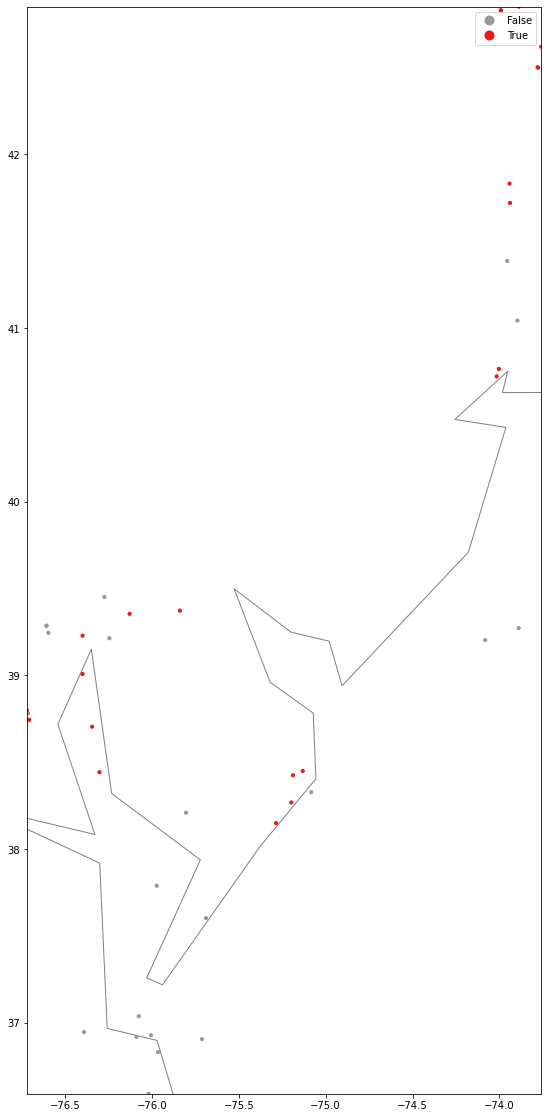

In [15]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_not_avail', 
         categorical=True, 
         cmap = 'Set1_r',
         markersize=10, 
         legend=True,
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

In [16]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.explore('erddap_not_avail',cmap = 'Set1_r',)

In [17]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_not_avail,geometry


In [18]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

In [19]:
df.shape

(43, 20)

In [20]:
gdf_final['Station Description'].astype(str)

0     Maryland Department of Natural Resources water...
1     Maryland Department of Natural Resources water...
2     Maryland Department of Natural Resources water...
3     Maryland Department of Natural Resources water...
4     Maryland Department of Natural Resources water...
5     Maryland Department of Natural Resources water...
6     Maryland Department of Natural Resources water...
7     Maryland Department of Natural Resources water...
8     Maryland Department of Natural Resources water...
9     Maryland Department of Natural Resources water...
10    Maryland Department of Natural Resources water...
11    Maryland Department of Natural Resources water...
12    Maryland Department of Natural Resources water...
13    Maryland Department of Natural Resources water...
14    Maryland Department of Natural Resources water...
15    Maryland Department of Natural Resources water...
16    Maryland Department of Natural Resources water...
17    Maryland Department of Natural Resources w